In [2]:
import torch as th
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## European option's price

$$ C(S,t) = S\Phi(d_1)-Ke^{-\gamma T}\Phi(d_2) \\
d_1={\ln\left({S_t\over K}\right)+\left(\gamma+{\sigma^2\over2}\right)T\over \sigma\sqrt{T}} \\
~ \\
\therefore \Delta = {\partial C\over \partial S} = \Phi(d_1)
$$



In [3]:
def european_option_delta(log_moneyness, expiry, volatility):
    """
    log_moneyness : log ratio of money over execution price
    """
    s, t, v = map(th.as_tensor, (log_moneyness, expiry, volatility))
    normal = th.distributions.Normal(loc=th.tensor(0.), scale=th.tensor(1.))
    delta = normal.cdf((s+(v**2/2)*t) / (v*th.sqrt(t)))
    return delta.item()

In [4]:
s = np.log(np.linspace(1, 2, 100))
t = np.linspace(0.1, 9.9, 100)
v = np.linspace(0.1, 1.9, 100)

s_delta = [european_option_delta(sin, t[0], v[0]) for sin in s]
t_delta = [european_option_delta(s[0], tin, v[0]) for tin in t]
v_delta = [european_option_delta(s[0], t[0], vin) for vin in v]

## Geometric Brownian Motion

$$ dS = \mu S dt + \sigma S dz \\ ~ \\
S = S_0 \exp\left[{\left(\mu-{\sigma^2\over 2}\right)t+\sigma\sqrt{t}Z_t}\right]
$$ 

In [22]:
def geonetric_brownian_motion(n_paths, maturity=30, dt=1/365, drift=0.0, volatility=0.2, device=None) -> th.Tensor:
    """
    @params n_paths: int
        num of assets or num of cases
    @params maturity: int
        num of timesteps to be expired
    @params dt: float
        real value of time of timestep
    @params drift: float
        drift of GBM ($\mu$)
    @params volatility: float
        volatility of GBM ($\sigma$)
    @return prices: th.Tensor, shape (maturity, n_paths)
        price trajectory 
    """
    normal_rand = th.randn(size=(maturity, n_paths), device=device)
    normal_rand[0, :] = 0.0
    
    noise_term = volatility * (dt ** 0.5) * normal_rand.cumsum(dim=0)   # normal_variable에 대한 cumsum이므로 variance가 dt만큼 가중돼 누적되어 나중에는 t만큼 벌어진다.
    t = th.linspace(0, maturity*dt, maturity)[:, None].to(noise_term)    # set same device with noise_term
    
    return th.exp((drift - 0.5*volatility**2)*t + noise_term)

In [26]:
geonetric_brownian_motion(2, 2)

tensor([[1.0000, 1.0000],
        [0.9879, 0.9811]])

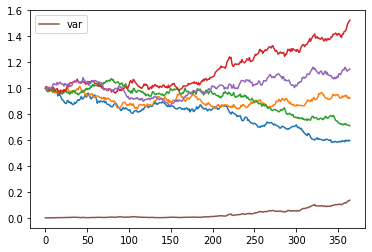

In [87]:
paths = geonetric_brownian_motion(5, maturity=365).T
for path in paths:
    plt.plot(path)
    
plt.plot(th.var(paths, axis=0), label='var')
plt.legend()

## Utils

### clamp

In [24]:
def clamp(x, lb, ub) -> th.Tensor:
    if not isinstance(x, th.Tensor):
        x = th.tensor(x, dtype=th.float32)
    if not isinstance(ub, th.Tensor):
        ub = th.tensor(ub, dtype=th.float32)
    if not isinstance(lb, th.Tensor):
        lb = th.tensor(lb, dtype=th.float32)
    
    x = th.min(th.max(x, lb), ub)
    x = th.where(lb < ub, x, (lb+ub)/2)
    return x

In [26]:
clamp(10, 15, 10)

tensor(12.5000)

### MultiLayer Perceptron (MLP)

In [ ]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, in_features, out_features, n_layers=4, n_units=32):
        super().__init__()
        self.layers = nn.Sequential()
        
        for n in range(n_layers):
            i = in_features if n==0 else n_units
            self.layers.add_module(name=f"linear{n+1}", module=nn.Linear(i, n_units))
            self.layers.add_module(name=f"relu{n+1}", module=nn.ReLU())
        
        self.layers.add_module(name="out_linear", module=nn.Linear(n_units, out_features))
    
    def forward(self, x):
        return self.layers(x)

### Entropic Loss

$$ L = -{1\over \lambda}\log E\left[e^{-\gamma X}\right] $$

여기서 $X$ : Profit&Loss

In [35]:
def pnl_entropic_loss(pnl, aversion=1.0) -> th.Tensor:
    return -th.mean(-th.exp(-aversion*pnl), dim=-1)

def pnl_entropic_premium(pnl, aversion=1.0) -> th.Tensor:
    return -th.log(pnl_entropic_loss(pnl, aversion=aversion))/aversion.view(-1)

In [82]:
pnl = th.vstack([th.normal(float(i//10), 1.0, size=(1000, )) for i in range(100)])
aversion = th.linspace(0.1, 1.1, 100)[:, None]

l1 = pnl_entropic_premium(pnl, aversion[50])
# l2 = pnl_entropic_premium(pnl[50], aversion)
l2 = pnl_entropic_premium(pnl, aversion)
l3 = pnl_entropic_loss(pnl, aversion)

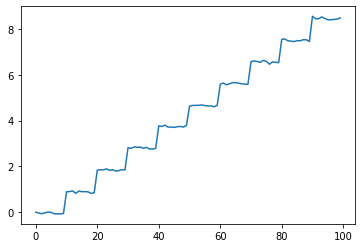

In [83]:
plt.plot(l2)

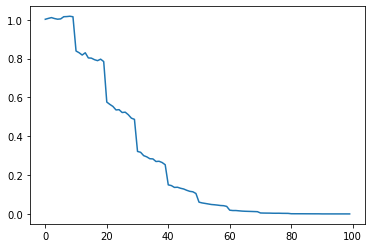

In [84]:
plt.plot(l3)

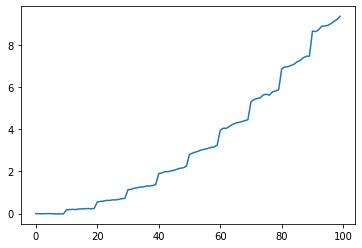

In [85]:
plt.plot(-th.log(l3))

### To numpy.array

utils to make th.tensor to np.array with detach and re-allocation to cpu

In [ ]:
def to_numpy(tensor: th.Tensor) -> np.array:
    return tensor.cpu().detach().numpy()

# No Transaction Band Network

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

import torch as th
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

In [12]:
from typing import Callable, Optional, Union, Tuple

## Presetting

In [6]:
FONTSIZE = 18
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 300
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

In [7]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

## Derivative Setting

- european option
- lookback option

In [ ]:
def european_option_payoff(prices: th.Tensor, strike=1.0) -> th.Tensor:
    """
    @param prices: th.Tensor, shape (n_paths, )
        prices of underlying assets at the time
    @return:
        payoff: th.Tensor, shape (n_paths)
    """
    return F.relu(prices-strike)

def lookback_option_payoff(prices_trajectory: th.Tensor, strike=1.03) -> th.Tensor:
    """
    @param prices_trajectory: th.Tensor, shape (n_steps, n_paths)
        prices of underlying assets for all time
    @return:
        payoff: th.Tensor, shape (n_steps, n_paths)
    """
    return F.relu(th.max(prices_trajectory, dim=0).values - strike)


### Experiment: European Option
- Compute P&L with hedging

$$ \delta_{t+1} = \pi(s_t, \delta_t| W_t) $$

$$
\Delta w_t = \delta_{t+1}\Delta P_{t} - c|\Delta \delta_{t}|P_{t}\\
=\text{gain from price movement under now holdings} + \text{loss from transaction(hedge move) under previous price}
$$

In [ ]:
def compute_pnl(hedging_model: nn.Module,
                price_generator: Callable[..., th.Tensor],
                payoff: Callable[[th.Tensor], th.Tensor],
                transaction_cost: float,
                **gen_kwargs) -> th.Tensor:
    """
    Parameters
    -------------
    - hedging_model: th.nn.Module
        hedging model to fit
    - price_generator: callable[..., th.Tensor]
        generator of price movement of derivative
    - payoff: callable[[th.Tensor], th.Tensor]
        payoff function of the derivative to hedge
    - transaction_cost: float
        transaction cost of underlying asset
    - gen_kwargs
        price_generator's kwargs
    
    Returns
    -------------
    pnl: th.Tensor, shape (n_paths, )
    """
    prices = price_generator(**gen_kwargs)  # prices over all time, shape (n_steps, n_paths)
    hedge = th.zeros_like(prices[0])        # positions, shape (n_paths, )
    pnl = 0
    
    for i in range(prices.shape[0] - 1):
        # env's observations
        log_moneyness = th.log(prices[i, :, None])  # obs_1, shape (n_paths, 1)
        time_expiry = th.full_like(log_moneyness, gen_kwargs['maturity'] - i)
        volatility = th.full_like(log_moneyness, volatility)
        state = th.cat([log_moneyness, time_expiry, volatility], dim=1)
        
        prev_hedge = hedge
        hedge = hedging_model(state, prev_hedge)
        
        # gain from price movement + loss from hedge movement
        pnl += hedge * (prices[i+1]-prices[i]) - transaction_cost * th.abs(hedge - prev_hedge) * prices[i]
    
    # buyer's option execution (so, it is loss for seller=(us))
    pnl -= payoff(prices)
    
    return pnl